# n-step Tabular SARSA

In the following notebook, we implement the *n-step SARSA*, also known as *SARSA-TD(n)* with a tabular Q-function. To that end, we use an environment with discrete state and action spaces. In the implementation below, we follow the details from the book Introduction to Reinforcement Learning by Sutton & Barto [1], Chapter 7.2. The complete pseudocode of the algorithm is illustrated in the figure below. Finally, we run a few experiments with varying $n$ and compare their results.

We use the *CliffWalking-v0* environment illustrated below, borrowed from the [CliffWalking Gymnasium webpage](https://gymnasium.farama.org/environments/toy_text/cliff_walking/). The goal in the *CliffWalking-v0* environment is to reach the terminal state in as few as possible steps. The terminal state in the environment is located at $[3,11]$ coordinates on the grid, and it is associated with an observation of $[47]$ (see the environment's webpage above for details). 


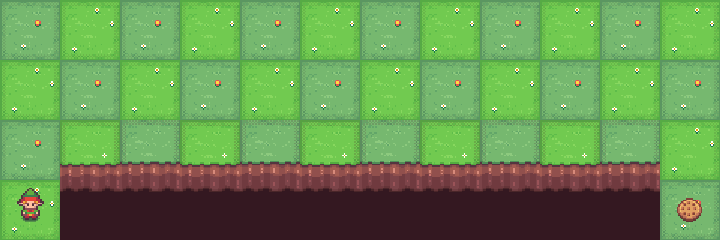


So, let's begin.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

Adding a few utility functions for plotting.

In [78]:
def plot_results(avg_scores, std_scores):
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    ax[0].set_title("Score averaged over different experiments")
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
def compare_results(data_dict, idx=0):
    """
    Compare the results from different experiments
    :param: data_dict = {name1: [avg_scores1, std_scores1], 
                         name2: [avg_scores2, std_scores2],
                         ...
                         nameN: [avg_scoresN, std_scoresN],}
    """
    
    # plot the results from a set of experiments
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 6))
    ax.set_title("Comparison of different RL algorithms' averaged score over a set of experiments")
    
    for item in data_dict:
        name = item
        avg_scores, std_scores = data_dict[name]
        
        n_episodes = len(avg_scores[0])
        n_experiments = len(avg_scores)

        avg_scores = np.array(avg_scores)
        avg_avg_scores = np.mean(avg_scores, axis=0)
        std_avg_scores = np.std(avg_scores, axis=0)

        upper_std_scores = avg_avg_scores + std_avg_scores
        lower_std_scores = avg_avg_scores - std_avg_scores
        x = range(1, n_episodes + 1)


        ax.plot(x[idx:], avg_avg_scores[idx:], label=f'{name} agent')
        ax.fill_between(x[idx:], upper_std_scores[idx:], lower_std_scores[idx:], 
                        where=(upper_std_scores[idx:] > lower_std_scores[idx:]), alpha=0.3)


    ax.set_ylabel('score')
    ax.legend()
    ax.grid()
    plt.show()

# Tabular n-step SARSA
Presented below is the *n-step SARSA* pseudocode obtained from [1]. Due to the algorithm's complexity with regards to index and time step tracking, we chose to implement the original n-step SARSA in its tabular form. In future notebooks, we intend to implement the algorithm using neural networks. To simplify the implementation process, we have modified our typical `while` loop to closely resemble the pseudocode presented herein.

<img src="../assets/SARSA_n_step_algorithm.png">


We begin with coding the agent class.

In [67]:
class TabularNStepSarsaAgent:
    def __init__(self, observation_dim, action_dim, learning_rate, gamma, epsilon, epsilon_dec,
                 epsilon_min, n):
        self.observation_dim = observation_dim
        self.gamma = gamma
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.n = n
        self.learning_rate = learning_rate
        self.tau = 0

        # initialize a Q-table
        self.q = np.random.randn(self.observation_dim, self.action_dim)
        
    def full_reset(self):
        self.q = np.random.randn(self.observation_dim, self.action_dim)
        self.tau = 0

    def reset(self):
        self.tau = 0

    def choose_action(self, observation):
        if np.random.rand() < self.epsilon:
            # take a random action
            action = np.random.randint(low=0, high=self.action_dim, size=1)[0]
        else:
            # take the greedy action
            q_values = self.q[observation, :]
            action = np.argmax(q_values)
        return action

    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])

    def value_estimate(self, observation, action):
        return self.q[observation, action]

    def learn(self, G, observation, action):
        q_value = self.q[observation, action]

        # compute the loss
        loss = G - q_value
        
        # update the (observation, action) entry in the Q-table
        self.q[observation, action] = self.q[observation, action] + self.learning_rate * loss

        # decrement epsilon
        self.decrement_epsilon()


Then, we define the `run_loop` function, which is responsible for running a single experiment for a set of hyperparameters.

In [71]:
def run_loop(env, agent, n_experiments, n_episodes, max_steps):
    # init empty lists for keeping scores
    scores = []
    avg_scores = []
    std_scores = []
    for ex_i in range(n_experiments):
        scores.append([])
        avg_scores.append([])
        std_scores.append([])
        
        # reset all the agent's parameters, also the Q-function
        agent.full_reset()

        # run all episodes
        for ep_i in range(n_episodes):
            # init episode variables
            score = 0
            t = 0
            done = False
            T = np.inf

            # reset the agent and the environment
            agent.reset()
            observation, info = env.reset()
            action = agent.choose_action(observation)

            # store initial state and action
            m_observations = [observation]
            m_actions = [action]
            m_rewards = [0.0]  # The None value is just a placeholder for the first unused element in the array.
                                # the reason for that inconvenience is for being able to use the same indexing as
                                # in the algorithm above. 

            # run a single episode
            while True:
                if t < T:
                    # as long you didn't encounter a terminal state, take the next action
                    next_observation, reward, terminated, truncated, info = env.step(action)
                    score += reward

                    # store state and reward
                    m_observations.append(next_observation)
                    m_rewards.append(reward)

                    # check for termination
                    if terminated or truncated or t==max_steps:
                        # set the terminal time
                        T = t + 1

                        # save scores
                        scores[ex_i].append(score)
                        avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                        std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
                    else:
                        # select and store the next action
                        next_action = agent.choose_action(next_observation)
                        m_actions.append(next_action)
                        action = next_action

                # set tau, the learning index
                tau = t - n + 1
                if tau >= 0:
                    # set the return to zero
                    G = 0
                    f = int(np.min([tau + n, T])) + 1  # The +1 is because the loop needs to be 
                                                        # terminated at np.min([tau + n, T])

                    # loop over the past n reward values
                    for i in range(tau + 1, f):
                        G = G + (np.power(agent.gamma, i - tau - 1) * m_rewards[i])

                    # if in n-steps a head from the learning index you didn't encounter a terminal state then, estimate
                    # the [tau + n] Q-value of the [tau + n] observation and action pair
                    if tau + n < T:
                        G = G + np.power(agent.gamma, agent.n) * agent.value_estimate(m_observations[tau + n],
                                                                                      m_actions[tau + n])
                    # update the Q-table
                    agent.learn(G, m_observations[tau], m_actions[tau])
                t += 1

                # if the learning time index exceeds the terminal time index, break the environment
                if (tau == T - 1):
                    break
            if (ep_i % 100)==0:
                print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f} |' +
                      f' Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
        env.close()
    return avg_scores, std_scores

Next, we run a set of experiments with identical hyperparameters' vectors and different $n$'s for different n-step SARSA executions. 

In [76]:
# make the environment
env = gym.make('CliffWalking-v0')

# set experiment results dictionary
results_data_dict = {}

# set the hyperparameters for the agent
N_EXPERIMENTS = 5
N_EPISODES = 5000
MAX_STEPS = 500
GAMMA = 0.99
LR = 0.001
EPSILON = 1.
EPSILON_MIN = 0.0001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.2)
OBSERVATION_DIM = env.observation_space.n
ACTION_DIM = env.action_space.n

# set the number of steps to use in the n-steps algorithm
n_list = [1, 2, 4, 8, 16, 32, 64]

for n in n_list:
    print(f"Initialize a new experiment of n-step SARSA with n = {str(n)}...")
    
    # initialize the agent
    agent = TabularNStepSarsaAgent(observation_dim=OBSERVATION_DIM, 
                                   action_dim=ACTION_DIM, 
                                   learning_rate=LR, 
                                   gamma=GAMMA, 
                                   epsilon=EPSILON, 
                                   epsilon_dec=EPSILON_DEC, 
                                   epsilon_min=EPSILON_MIN, n=n)

    # run single experiment
    avg_scores, std_scores = run_loop(env=env, 
                                      agent=agent, 
                                      n_experiments=N_EXPERIMENTS, 
                                      n_episodes=N_EPISODES, 
                                      max_steps=MAX_STEPS)

    # save experiment's data for later comparison
    results_data_dict[f"n = {str(n)}"] = avg_scores, std_scores

Initialize a new experiment of n-step SARSA with n = 1...
| Experiment:    1 | Episode:    0 | Score: -4362.000 | Avg score: -4362.000 |
| Experiment:    1 | Episode:  100 | Score: -600.000 | Avg score: -550.500 |
| Experiment:    1 | Episode:  200 | Score: -501.000 | Avg score: -538.620 |
| Experiment:    1 | Episode:  300 | Score: -699.000 | Avg score: -560.400 |
| Experiment:    1 | Episode:  400 | Score: -119.000 | Avg score: -365.400 |
| Experiment:    1 | Episode:  500 | Score: -59.000 | Avg score: -136.020 |
| Experiment:    1 | Episode:  600 | Score: -138.000 | Avg score: -123.570 |
| Experiment:    1 | Episode:  700 | Score: -69.000 | Avg score: -119.380 |
| Experiment:    1 | Episode:  800 | Score: -71.000 | Avg score: -118.300 |
| Experiment:    1 | Episode:  900 | Score: -81.000 | Avg score: -117.220 |
| Experiment:    1 | Episode: 1000 | Score: -110.000 | Avg score: -118.310 |
| Experiment:    1 | Episode: 1100 | Score: -114.000 | Avg score: -121.270 |
| Experiment:    1 |

| Experiment:    3 | Episode:  900 | Score: -151.000 | Avg score: -167.380 |
| Experiment:    3 | Episode: 1000 | Score: -93.000 | Avg score: -161.550 |
| Experiment:    3 | Episode: 1100 | Score: -101.000 | Avg score: -121.410 |
| Experiment:    3 | Episode: 1200 | Score: -135.000 | Avg score: -124.460 |
| Experiment:    3 | Episode: 1300 | Score: -145.000 | Avg score: -120.440 |
| Experiment:    3 | Episode: 1400 | Score: -115.000 | Avg score: -121.850 |
| Experiment:    3 | Episode: 1500 | Score: -113.000 | Avg score: -119.820 |
| Experiment:    3 | Episode: 1600 | Score: -121.000 | Avg score: -112.940 |
| Experiment:    3 | Episode: 1700 | Score: -85.000 | Avg score: -110.730 |
| Experiment:    3 | Episode: 1800 | Score: -129.000 | Avg score: -109.490 |
| Experiment:    3 | Episode: 1900 | Score: -77.000 | Avg score: -110.320 |
| Experiment:    3 | Episode: 2000 | Score: -93.000 | Avg score: -102.520 |
| Experiment:    3 | Episode: 2100 | Score: -41.000 | Avg score: -100.770 |
| Ex

| Experiment:    5 | Episode: 1800 | Score: -95.000 | Avg score: -96.590 |
| Experiment:    5 | Episode: 1900 | Score: -121.000 | Avg score: -95.870 |
| Experiment:    5 | Episode: 2000 | Score: -53.000 | Avg score: -89.320 |
| Experiment:    5 | Episode: 2100 | Score: -85.000 | Avg score: -91.400 |
| Experiment:    5 | Episode: 2200 | Score: -91.000 | Avg score: -86.590 |
| Experiment:    5 | Episode: 2300 | Score: -79.000 | Avg score: -81.220 |
| Experiment:    5 | Episode: 2400 | Score: -81.000 | Avg score: -83.970 |
| Experiment:    5 | Episode: 2500 | Score: -69.000 | Avg score: -79.960 |
| Experiment:    5 | Episode: 2600 | Score: -37.000 | Avg score: -85.000 |
| Experiment:    5 | Episode: 2700 | Score: -83.000 | Avg score: -77.250 |
| Experiment:    5 | Episode: 2800 | Score: -302.000 | Avg score: -90.430 |
| Experiment:    5 | Episode: 2900 | Score: -115.000 | Avg score: -81.070 |
| Experiment:    5 | Episode: 3000 | Score: -101.000 | Avg score: -81.750 |
| Experiment:    5 | 

| Experiment:    2 | Episode: 2700 | Score: -71.000 | Avg score: -68.980 |
| Experiment:    2 | Episode: 2800 | Score: -75.000 | Avg score: -75.770 |
| Experiment:    2 | Episode: 2900 | Score: -30.000 | Avg score: -68.110 |
| Experiment:    2 | Episode: 3000 | Score: -69.000 | Avg score: -73.200 |
| Experiment:    2 | Episode: 3100 | Score: -50.000 | Avg score: -74.630 |
| Experiment:    2 | Episode: 3200 | Score: -53.000 | Avg score: -73.840 |
| Experiment:    2 | Episode: 3300 | Score: -47.000 | Avg score: -76.020 |
| Experiment:    2 | Episode: 3400 | Score: -47.000 | Avg score: -65.790 |
| Experiment:    2 | Episode: 3500 | Score: -53.000 | Avg score: -45.430 |
| Experiment:    2 | Episode: 3600 | Score: -71.000 | Avg score: -60.070 |
| Experiment:    2 | Episode: 3700 | Score: -69.000 | Avg score: -51.460 |
| Experiment:    2 | Episode: 3800 | Score: -55.000 | Avg score: -60.750 |
| Experiment:    2 | Episode: 3900 | Score: -82.000 | Avg score: -50.000 |
| Experiment:    2 | Epis

| Experiment:    4 | Episode: 3800 | Score: -173.000 | Avg score: -63.880 |
| Experiment:    4 | Episode: 3900 | Score: -38.000 | Avg score: -59.730 |
| Experiment:    4 | Episode: 4000 | Score: -79.000 | Avg score: -57.160 |
| Experiment:    4 | Episode: 4100 | Score: -37.000 | Avg score: -56.690 |
| Experiment:    4 | Episode: 4200 | Score: -40.000 | Avg score: -56.900 |
| Experiment:    4 | Episode: 4300 | Score: -29.000 | Avg score: -65.280 |
| Experiment:    4 | Episode: 4400 | Score: -35.000 | Avg score: -59.170 |
| Experiment:    4 | Episode: 4500 | Score: -34.000 | Avg score: -43.900 |
| Experiment:    4 | Episode: 4600 | Score: -70.000 | Avg score: -52.840 |
| Experiment:    4 | Episode: 4700 | Score: -41.000 | Avg score: -50.320 |
| Experiment:    4 | Episode: 4800 | Score: -53.000 | Avg score: -46.740 |
| Experiment:    4 | Episode: 4900 | Score: -57.000 | Avg score: -45.290 |
| Experiment:    5 | Episode:    0 | Score: -996.000 | Avg score: -996.000 |
| Experiment:    5 | E

| Experiment:    2 | Episode:  100 | Score: -501.000 | Avg score: -592.080 |
| Experiment:    2 | Episode:  200 | Score: -214.000 | Avg score: -315.810 |
| Experiment:    2 | Episode:  300 | Score: -96.000 | Avg score: -277.850 |
| Experiment:    2 | Episode:  400 | Score: -152.000 | Avg score: -269.270 |
| Experiment:    2 | Episode:  500 | Score: -59.000 | Avg score: -183.340 |
| Experiment:    2 | Episode:  600 | Score: -137.000 | Avg score: -197.970 |
| Experiment:    2 | Episode:  700 | Score: -70.000 | Avg score: -159.630 |
| Experiment:    2 | Episode:  800 | Score: -17.000 | Avg score: -146.120 |
| Experiment:    2 | Episode:  900 | Score: -87.000 | Avg score: -176.000 |
| Experiment:    2 | Episode: 1000 | Score: -29.000 | Avg score: -143.590 |
| Experiment:    2 | Episode: 1100 | Score: -48.000 | Avg score: -113.410 |
| Experiment:    2 | Episode: 1200 | Score: -53.000 | Avg score: -93.100 |
| Experiment:    2 | Episode: 1300 | Score: -93.000 | Avg score: -106.170 |
| Experim

| Experiment:    4 | Episode: 1100 | Score: -67.000 | Avg score: -110.160 |
| Experiment:    4 | Episode: 1200 | Score: -32.000 | Avg score: -94.640 |
| Experiment:    4 | Episode: 1300 | Score: -242.000 | Avg score: -78.890 |
| Experiment:    4 | Episode: 1400 | Score: -29.000 | Avg score: -83.510 |
| Experiment:    4 | Episode: 1500 | Score: -45.000 | Avg score: -68.690 |
| Experiment:    4 | Episode: 1600 | Score: -181.000 | Avg score: -65.190 |
| Experiment:    4 | Episode: 1700 | Score: -40.000 | Avg score: -59.260 |
| Experiment:    4 | Episode: 1800 | Score: -25.000 | Avg score: -31.180 |
| Experiment:    4 | Episode: 1900 | Score: -23.000 | Avg score: -40.710 |
| Experiment:    4 | Episode: 2000 | Score: -17.000 | Avg score: -31.990 |
| Experiment:    4 | Episode: 2100 | Score: -28.000 | Avg score: -29.810 |
| Experiment:    4 | Episode: 2200 | Score: -17.000 | Avg score: -29.390 |
| Experiment:    4 | Episode: 2300 | Score: -148.000 | Avg score: -24.770 |
| Experiment:    4 | 

| Experiment:    1 | Episode: 2300 | Score: -17.000 | Avg score: -17.560 |
| Experiment:    1 | Episode: 2400 | Score: -17.000 | Avg score: -18.250 |
| Experiment:    1 | Episode: 2500 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    1 | Episode: 2600 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    1 | Episode: 2700 | Score: -17.000 | Avg score: -17.090 |
| Experiment:    1 | Episode: 2800 | Score: -17.000 | Avg score: -17.240 |
| Experiment:    1 | Episode: 2900 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    1 | Episode: 3000 | Score: -17.000 | Avg score: -17.100 |
| Experiment:    1 | Episode: 3100 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    1 | Episode: 3200 | Score: -17.000 | Avg score: -17.100 |
| Experiment:    1 | Episode: 3300 | Score: -17.000 | Avg score: -17.020 |
| Experiment:    1 | Episode: 3400 | Score: -17.000 | Avg score: -17.100 |
| Experiment:    1 | Episode: 3500 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    1 | Epis

| Experiment:    3 | Episode: 3900 | Score: -17.000 | Avg score: -17.200 |
| Experiment:    3 | Episode: 4000 | Score: -17.000 | Avg score: -17.060 |
| Experiment:    3 | Episode: 4100 | Score: -17.000 | Avg score: -17.160 |
| Experiment:    3 | Episode: 4200 | Score: -17.000 | Avg score: -17.290 |
| Experiment:    3 | Episode: 4300 | Score: -17.000 | Avg score: -17.040 |
| Experiment:    3 | Episode: 4400 | Score: -17.000 | Avg score: -17.040 |
| Experiment:    3 | Episode: 4500 | Score: -17.000 | Avg score: -17.020 |
| Experiment:    3 | Episode: 4600 | Score: -17.000 | Avg score: -17.400 |
| Experiment:    3 | Episode: 4700 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    3 | Episode: 4800 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    3 | Episode: 4900 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    4 | Episode:    0 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    4 | Episode:  100 | Score: -120.000 | Avg score: -287.670 |
| Experiment:    4 | 

| Experiment:    1 | Episode:  100 | Score: -69.000 | Avg score: -367.650 |
| Experiment:    1 | Episode:  200 | Score: -37.000 | Avg score: -278.800 |
| Experiment:    1 | Episode:  300 | Score: -72.000 | Avg score: -166.090 |
| Experiment:    1 | Episode:  400 | Score: -17.000 | Avg score: -177.930 |
| Experiment:    1 | Episode:  500 | Score: -37.000 | Avg score: -168.870 |
| Experiment:    1 | Episode:  600 | Score: -70.000 | Avg score: -93.050 |
| Experiment:    1 | Episode:  700 | Score: -41.000 | Avg score: -80.460 |
| Experiment:    1 | Episode:  800 | Score: -17.000 | Avg score: -152.910 |
| Experiment:    1 | Episode:  900 | Score: -17.000 | Avg score: -41.440 |
| Experiment:    1 | Episode: 1000 | Score: -17.000 | Avg score: -62.170 |
| Experiment:    1 | Episode: 1100 | Score: -17.000 | Avg score: -19.750 |
| Experiment:    1 | Episode: 1200 | Score: -17.000 | Avg score: -28.570 |
| Experiment:    1 | Episode: 1300 | Score: -17.000 | Avg score: -29.100 |
| Experiment:    1 

| Experiment:    3 | Episode: 1100 | Score: -19.000 | Avg score: -37.550 |
| Experiment:    3 | Episode: 1200 | Score: -19.000 | Avg score: -28.820 |
| Experiment:    3 | Episode: 1300 | Score: -17.000 | Avg score: -57.790 |
| Experiment:    3 | Episode: 1400 | Score: -19.000 | Avg score: -18.460 |
| Experiment:    3 | Episode: 1500 | Score: -17.000 | Avg score: -45.270 |
| Experiment:    3 | Episode: 1600 | Score: -17.000 | Avg score: -18.700 |
| Experiment:    3 | Episode: 1700 | Score: -19.000 | Avg score: -21.910 |
| Experiment:    3 | Episode: 1800 | Score: -19.000 | Avg score: -20.960 |
| Experiment:    3 | Episode: 1900 | Score: -23.000 | Avg score: -21.430 |
| Experiment:    3 | Episode: 2000 | Score: -19.000 | Avg score: -21.600 |
| Experiment:    3 | Episode: 2100 | Score: -19.000 | Avg score: -23.950 |
| Experiment:    3 | Episode: 2200 | Score: -19.000 | Avg score: -19.360 |
| Experiment:    3 | Episode: 2300 | Score: -19.000 | Avg score: -20.730 |
| Experiment:    3 | Epis

| Experiment:    5 | Episode: 2000 | Score: -19.000 | Avg score: -26.950 |
| Experiment:    5 | Episode: 2100 | Score: -17.000 | Avg score: -17.720 |
| Experiment:    5 | Episode: 2200 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    5 | Episode: 2300 | Score: -17.000 | Avg score: -17.180 |
| Experiment:    5 | Episode: 2400 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    5 | Episode: 2500 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    5 | Episode: 2600 | Score: -17.000 | Avg score: -17.200 |
| Experiment:    5 | Episode: 2700 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    5 | Episode: 2800 | Score: -17.000 | Avg score: -17.180 |
| Experiment:    5 | Episode: 2900 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    5 | Episode: 3000 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    5 | Episode: 3100 | Score: -17.000 | Avg score: -17.400 |
| Experiment:    5 | Episode: 3200 | Score: -17.000 | Avg score: -17.220 |
| Experiment:    5 | Epis

| Experiment:    2 | Episode: 3900 | Score: -17.000 | Avg score: -17.180 |
| Experiment:    2 | Episode: 4000 | Score: -17.000 | Avg score: -17.500 |
| Experiment:    2 | Episode: 4100 | Score: -17.000 | Avg score: -17.180 |
| Experiment:    2 | Episode: 4200 | Score: -17.000 | Avg score: -17.160 |
| Experiment:    2 | Episode: 4300 | Score: -17.000 | Avg score: -17.160 |
| Experiment:    2 | Episode: 4400 | Score: -17.000 | Avg score: -17.140 |
| Experiment:    2 | Episode: 4500 | Score: -17.000 | Avg score: -17.160 |
| Experiment:    2 | Episode: 4600 | Score: -17.000 | Avg score: -17.140 |
| Experiment:    2 | Episode: 4700 | Score: -17.000 | Avg score: -17.140 |
| Experiment:    2 | Episode: 4800 | Score: -17.000 | Avg score: -17.120 |
| Experiment:    2 | Episode: 4900 | Score: -17.000 | Avg score: -17.140 |
| Experiment:    3 | Episode:    0 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    3 | Episode:  100 | Score: -15.000 | Avg score: -480.120 |
| Experiment:    3 | E

| Experiment:    4 | Episode: 4900 | Score: -17.000 | Avg score: -17.000 |
| Experiment:    5 | Episode:    0 | Score: -4065.000 | Avg score: -4065.000 |
| Experiment:    5 | Episode:  100 | Score: -798.000 | Avg score: -779.190 |
| Experiment:    5 | Episode:  200 | Score: -19.000 | Avg score: -399.910 |
| Experiment:    5 | Episode:  300 | Score: -19.000 | Avg score: -67.970 |
| Experiment:    5 | Episode:  400 | Score: -19.000 | Avg score: -27.660 |
| Experiment:    5 | Episode:  500 | Score: -501.000 | Avg score: -247.180 |
| Experiment:    5 | Episode:  600 | Score: -109.000 | Avg score: -369.810 |
| Experiment:    5 | Episode:  700 | Score: -96.000 | Avg score: -105.370 |
| Experiment:    5 | Episode:  800 | Score: -207.000 | Avg score: -128.880 |
| Experiment:    5 | Episode:  900 | Score: -119.000 | Avg score: -93.070 |
| Experiment:    5 | Episode: 1000 | Score: -103.000 | Avg score: -118.160 |
| Experiment:    5 | Episode: 1100 | Score: -91.000 | Avg score: -100.900 |
| Exper

| Experiment:    2 | Episode:  600 | Score: -501.000 | Avg score: -502.980 |
| Experiment:    2 | Episode:  700 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    2 | Episode:  800 | Score: -501.000 | Avg score: -502.980 |
| Experiment:    2 | Episode:  900 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    2 | Episode: 1000 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    2 | Episode: 1100 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    2 | Episode: 1200 | Score: -501.000 | Avg score: -504.960 |
| Experiment:    2 | Episode: 1300 | Score: -501.000 | Avg score: -502.980 |
| Experiment:    2 | Episode: 1400 | Score: -501.000 | Avg score: -501.990 |
| Experiment:    2 | Episode: 1500 | Score: -600.000 | Avg score: -502.980 |
| Experiment:    2 | Episode: 1600 | Score: -501.000 | Avg score: -501.990 |
| Experiment:    2 | Episode: 1700 | Score: -501.000 | Avg score: -496.550 |
| Experiment:    2 | Episode: 1800 | Score: -501.000 | Avg score: -497.430 |

| Experiment:    4 | Episode: 1300 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    4 | Episode: 1400 | Score: -501.000 | Avg score: -501.990 |
| Experiment:    4 | Episode: 1500 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    4 | Episode: 1600 | Score: -501.000 | Avg score: -501.990 |
| Experiment:    4 | Episode: 1700 | Score: -501.000 | Avg score: -502.980 |
| Experiment:    4 | Episode: 1800 | Score: -501.000 | Avg score: -501.990 |
| Experiment:    4 | Episode: 1900 | Score: -501.000 | Avg score: -502.980 |
| Experiment:    4 | Episode: 2000 | Score: -501.000 | Avg score: -504.960 |
| Experiment:    4 | Episode: 2100 | Score: -501.000 | Avg score: -501.990 |
| Experiment:    4 | Episode: 2200 | Score: -501.000 | Avg score: -502.980 |
| Experiment:    4 | Episode: 2300 | Score: -501.000 | Avg score: -501.000 |
| Experiment:    4 | Episode: 2400 | Score: -501.000 | Avg score: -502.980 |
| Experiment:    4 | Episode: 2500 | Score: -501.000 | Avg score: -504.960 |

Here are the results.

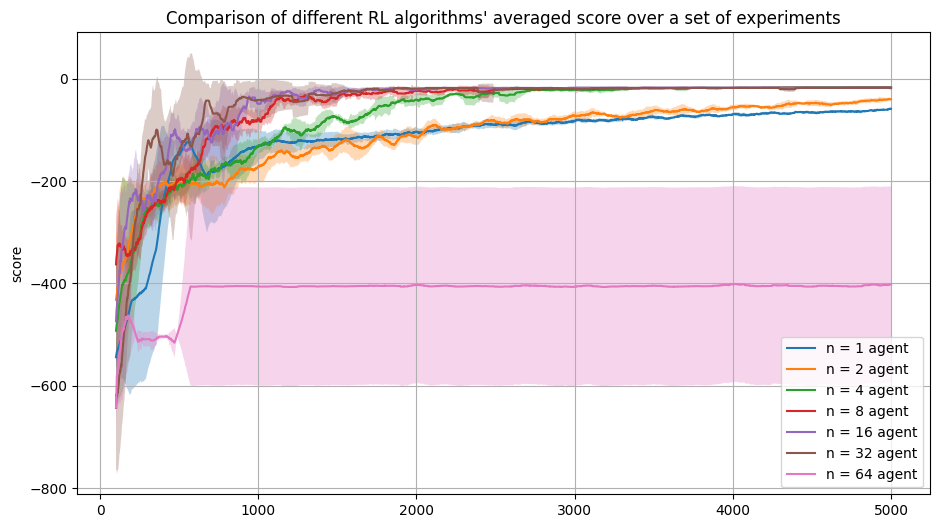

In [80]:
compare_results(results_data_dict, idx=100)

## Conclusion

We have implemented the on-policy Reinforcement Learning (RL) algorithm, namely, n-step SARSA in its tabular version, with varying values of $n$, and conducted a comparative analysis of their results. To assess the effectiveness of each n-step algorithm, the most suitable comparison would be the difference between the action-value estimation of each algorithm and the actual action-value function values. However, given that the true action-value function of the problem is unknown, we instead opted to compare the average-average score for different values of $n$. To achieve this, we calculated the score average of every $100$ steps in the environment, and subsequently, averaged these across different experiments to obtain the plot presented herein.

Our findings reveal that in general, higher values of $n$ lead to faster convergence to the final score, albeit at the expense of additional time for each update step. Additionally, based on the current hyperparameters set, we observed that for this particular environment, the optimal values of $n$ that yield the highest scores are $n\in\lbrace 8, 16, 32\rbrace$, whereas for $n=64$, the agent appears to experience learning difficulties.

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)

## Contact
In case you have any comments, corrections, or inquiries regarding the material presented in the notebook, please feel free to contact me via email at elkabetz.roy@gmail.com.